In [1]:
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import openpyxl
import numpy as np  
import imageio
from pygazeanalyser.gazeplotter import draw_fixations, draw_heatmap, draw_scanpath, draw_raw
import os
import cv2
from pathlib import Path
import shutil
import re

In [2]:
background_images_path = './data/expert_data/expert_images/'

# get the image size for scaling later
background_im = glob.glob(background_images_path+"/*.png")
print(background_im[1])
with Image.open(background_im[1]) as im:
    im_width, im_height = im.size

print(im_width, im_height)

./data/expert_data/expert_images/8939_OS_2021_widefield_report.png
5375 2668


In [3]:
path = "/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/expert_images/RLS_085_OS_TC.jpg"

with Image.open(path) as im:
    im_width, im_height = im.size

print(im_width, im_height)

3508 2158


In [2]:
def create_masks(fixations_folder): 
    ## First draws heatmaps onto OCT images using fixations 
    white_image = './data/expert_data/wsi.png'
    unbinary_masks_path = str(Path(fixations_folder).parents[0])+"/unbinarized_masks"
    for data in glob.glob(fixations_folder+"/*.csv"): 
        file_name = data.split("/")[-1]
        if not os.path.exists(unbinary_masks_path):
            os.makedirs(unbinary_masks_path)
        pid = str(Path(data).parents[1]).split("/")[-1]
        iid = data.split("/")[-1].split("_")[2]
        sub_df = pd.read_csv(data)

        sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
        sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
        draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=white_image, alpha=0.5, savefilename=None)
        plt.savefig(unbinary_masks_path+"/"+str(pid)+"_"+str(iid)+"_nonbinary_mask.png")

        plt.close('all')
        
    ## Creates binary mask from heatmaps (same as create_binary_heatmaps)
    for file in glob.glob(unbinary_masks_path+"/*.png"):
        file_name = Path(file).stem.split("_nonbinary_mask")[0] 
        img = imageio.imread(file)
        test_img = img.copy()[:,:,0]
        test_img[:, im_width:] = [255]
        binary_masks_path = str(Path(unbinary_masks_path).parents[0])+"/binarized_masks"
        if not os.path.exists(binary_masks_path):
            os.makedirs(binary_masks_path)
        cv2.imwrite(binary_masks_path+"/"+file_name+"_binary_mask.png", test_img)

In [ ]:
im_width

In [3]:
def create_masks_noncontrol(fixations_folder): 
    ## First draws heatmaps onto OCT images using fixations 
    white_image = './data/expert_data/wsi.png'
    unbinary_masks_path = str(Path(fixations_folder).parents[0])+"/unbinarized_masks"
    for data in glob.glob(fixations_folder+"/*.csv"): 
        file_name = data.split("/")[-1]
        if not os.path.exists(unbinary_masks_path):
            os.makedirs(unbinary_masks_path)
        pid = str(Path(data).parents[1]).split("/")[-1]
        new_str = re.findall(r"RLS_[0-9]{3}_[A-Z]{2}",data)
        iid = re.findall(r"[0-9]{3}_[A-Z]{2}", new_str[0])
        sub_df = pd.read_csv(data)

        img_name = data.split("/")[-1].split("_",2)[2].split(".csv")[0]
        img_folder ="/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/expert_images/"
        img_path = img_folder+img_name+".jpg"
        with Image.open(img_path) as im:
            im_width, im_height = im.size

        sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
        sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
        draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=white_image, alpha=0.5, savefilename=None)
        plt.savefig(unbinary_masks_path+"/"+str(pid)+"_"+str(iid[0])+"_nonbinary_mask.png")

        plt.close('all')
        
    ## Creates binary mask from heatmaps (same as create_binary_heatmaps)
    for file in glob.glob(unbinary_masks_path+"/*.png"):
        file_name = Path(file).stem.split("_nonbinary_mask")[0] 
        img = imageio.imread(file)
        test_img = img.copy()[:,:,0]
        test_img[:, im_width:] = [255]
        binary_masks_path = str(Path(unbinary_masks_path).parents[0])+"/binarized_masks"
        if not os.path.exists(binary_masks_path):
            os.makedirs(binary_masks_path)
        cv2.imwrite(binary_masks_path+"/"+file_name+"_binary_mask.png", test_img)

In [4]:
def create_binary_heatmaps(unbinary_masks_path): 
    # Create binary mask from heatmaps
    for file in glob.glob(unbinary_masks_path+"/*.png"):
        print(file)
        file_name = Path(file).stem.split("__nonbinary_mask")[0] 
        img = imageio.imread(file)
        test_img = img.copy()[:,:,0]
        test_img[:, 2999:] = [255]
        binary_masks_path = str(Path(unbinary_masks_path).parents[1])+"/binarized_masks"
        if not os.path.exists(binary_masks_path):
            os.makedirs(binary_masks_path)
        cv2.imwrite(binary_masks_path+"/"+file_name+"_binary_mask.png", test_img)

In [5]:
def create_heatmaps(fixations_folder):
     heatmap_path = str(Path(fixations_folder).parents[0])+"/heatmaps"
     for data in glob.glob(fixations_folder+"/*.csv"): 
          img_name = data.split("/")[-1].split("_",2)[2].split(".csv")[0]
          img_folder ="/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/expert_images/"
          if not os.path.exists(heatmap_path):
                    os.makedirs(heatmap_path)
          pid = str(Path(data).parents[1]).split("/")[-1]
          
          # #if  control 
          # iid = data.split("/")[-1].split("_")[2]

          # If noncontrol 
          new_str = re.findall(r"RLS_[0-9]{3}_[A-Z]{2}",data)
          iid = re.findall(r"[0-9]{3}_[A-Z]{2}", new_str[0])
          sub_df = pd.read_csv(data)

          img_path = img_folder+img_name+".jpg"
          with Image.open(img_path) as im:
               im_width, im_height = im.size
          

          sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
          sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
          
          # # if control 
          # draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=img_folder+img_name+".png", alpha=0.5, savefilename=None)

          # if non-control 
          draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=img_folder+img_name+".jpg", alpha=0.5, savefilename=None)
          plt.savefig(heatmap_path+"/"+str(pid)+"_"+str(iid[0])+"_heatmap.png")

          plt.close('all')


In [6]:
def get_original_image(fixations_folder):
    #Find original image and save with naming convention
     original_path = str(Path(fixations_folder).parents[0])+"/original_image"
     for data in glob.glob(fixations_folder+"/*.csv"): 
          img_name = data.split("/")[-1].split("_",2)[2].split(".csv")[0]
          print(img_name)
          img_folder ="/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/expert_images/"
          if not os.path.exists(original_path):
                    os.makedirs(original_path)
          pid = str(Path(data).parents[1]).split("/")[-1]
          iid = data.split("/")[-1].split("_")[2]
          print(pid, iid)
          shutil.copyfile(img_folder+img_name+".png", original_path+"/"+str(pid)+"_"+str(iid)+"_original.png")

In [7]:
def get_original_image_noncontrol(fixations_folder):
    #Find original image and save with naming convention
     original_path = str(Path(fixations_folder).parents[0])+"/original_image"
     for data in glob.glob(fixations_folder+"/*.csv"): 
          img_name = data.split("/")[-1].split("_",2)[2].split(".csv")[0]
          print(img_name)
          img_folder ="/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/expert_images/"
          if not os.path.exists(original_path):
                    os.makedirs(original_path)
          pid = str(Path(data).parents[1]).split("/")[-1]
          new_str = re.findall(r"RLS_[0-9]{3}_[A-Z]{2}",data)
          iid = re.findall(r"[0-9]{3}_[A-Z]{2}", new_str[0])
          print(pid, iid)
          shutil.copyfile(img_folder+img_name+".jpg", original_path+"/"+str(pid)+"_"+str(iid[0])+"_original.png")

In [7]:
def resize_image(input_folder, resized_folder): 
    for image in glob.glob(input_folder+"/*.png"): 
        print(image)
        file_name = image.split("/")[-1]
        with Image.open(image) as im:
            im_width, im_height = im.size
            print(im_width, im_height)
        if im_height==2668: 
            shutil.copyfile(image, resized_folder+"/"+file_name)
            print("moved to " + resized_folder+"/"+file_name) 
        else:
            img = cv2.imread(image)
            image_re = cv2.resize(img, (5375,2668), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(resized_folder+"/"+file_name, image_re)
            print("resized")

In [8]:
def invert_bw_masks(input_folder): 
    # Change black/white to white/black
    ## Changes region of interest from black to white 
    output_folder = str(Path(input_folder).parents[0])+"/inverted_masks"
    for mask in glob.glob(input_folder+"/*.png"): 
        file_name = mask.split("/")[-1]
        img = cv2.imread(mask)
        th, img_bin = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY_INV)
        if not os.path.exists(output_folder):
                    os.makedirs(output_folder)
        cv2.imwrite(output_folder+"/"+file_name, img_bin)

In [9]:
def get_rnfl_image(input_folder): 
## input_folder: original image folder for UNET input images OR inverted masks folder for UNET ground truth images
## Get topright rnfl image
    #output_folder = str(Path(input_folder).parents[0])+"/rnfl_"+input_folder.split("/")[-1] ## For Top Right RNFL (RNFL Probability)
    output_folder = str(Path(input_folder).parents[0])+"/rnfl_circ_"+input_folder.split("/")[-1] ## For Top Right RNFL (Circulapapillatory RNFL)
    for full_img in glob.glob(input_folder+"/*.png"): 
        file_name = full_img.split("/")[-1]
        img = cv2.imread(full_img)
       #cropped_image = img[:1750, 3250:] ## For Top Right RNFL (RNFL Probability)
        cropped_image = img[:1600, :3000] ## For Top Left RNFL (Circulapapillatory RNFL)
        if not os.path.exists(output_folder):
                    os.makedirs(output_folder)
        cv2.imwrite(output_folder+"/"+file_name, cropped_image)

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

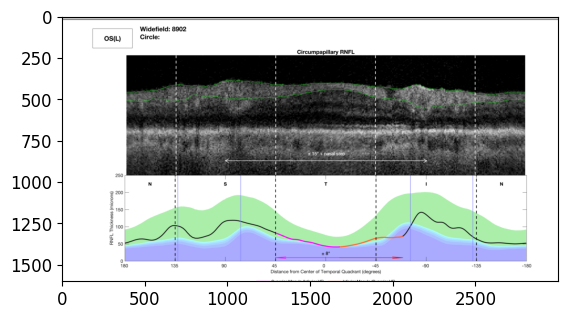

In [6]:
img = cv2.imread("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem003/original_image/eem003_8902_original.png")
cropped_image = img[:1600, :3000]
plt.imshow(cropped_image)

In [9]:
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-09/eem008/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-15/eem009/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-09/eem008/original_image")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-15/eem009/original_image")

In [11]:
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-19/eem001/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-19/eem002/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-19/eem001/original_image")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-19/eem002/original_image")

In [12]:
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem003/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem003/original_image")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/original_image")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem005/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem005/original_image")

In [13]:
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-02/eem006/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-02/eem007/inverted_masks")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-02/eem006/original_image")
get_rnfl_image("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-02/eem007/original_image")

In [ ]:
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-15/eem009/eem009_fixations")
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/2-09/eem008/eem008_fixations")

Trying to understand if we should subset noise in fixation data

In [17]:
# See what duration of fixations are plotted 

from pygazeanalyser.gazeplotter import parse_fixations

In [15]:
im_width, im_height = 5375, 2668
sub_df = pd.read_csv("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/fixations_eem004/fixations_Glaucoma_8939_OS_2021_widefield_report.csv")
sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
#draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration'

parse_fixations(sub_df[[]])

In [19]:
fixations = parse_fixations(sub_df[['im_pos_x', 'im_pos_y', 'duration']])
fixations_df = pd.DataFrame(fixations)

In [22]:
print("25th Percentile: ", fixations_df['dur'].quantile(0.25))
print(fixations_df['dur'].quantile(0.50))
print(fixations_df['dur'].quantile(0.75))
print(fixations_df['dur'].quantile(1))

25th Percentile:  121.0350000183098
161.38000000501052
217.86199999041855
217.8639999765437


In [46]:
# Plot side-by-side after subsetting fixations by 25th percentile 

subset_df = fixations_df[fixations_df['dur'] >= fixations_df['dur'].quantile(0.75)]
print("Original DF: ", fixations_df.info)
print("Subsetted DF: ", subset_df.info)

Original DF:  <bound method DataFrame.info of                x            y       dur
0    4650.875047   924.580976  145.2415
1    3353.380144  1478.311068   80.6900
2    2503.805965  1688.626815   80.6900
3    2046.294976  1470.377301   84.7245
4    1864.033978  1852.656371   84.7245
..           ...          ...       ...
373    69.435001  2317.528036  157.3455
374    15.254026  2290.314691  157.3455
375   203.034050  2237.168790  157.3455
376   321.801535  2317.855628  104.8975
377    12.673393  2383.229454  104.8975

[378 rows x 3 columns]>
Subsetted DF:  <bound method DataFrame.info of                x            y       dur
24   1414.941803  2241.914102  217.8620
25   1376.812376  2227.560647  217.8620
26   1428.765982  2217.122074  217.8620
27   1361.586396  2210.328518  217.8620
28   1106.073104  2307.858351  217.8620
..           ...          ...       ...
356  2970.510915   752.006280  217.8635
357  3044.382654   756.755886  217.8635
358  2954.077281   729.008932  217.8635
35

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

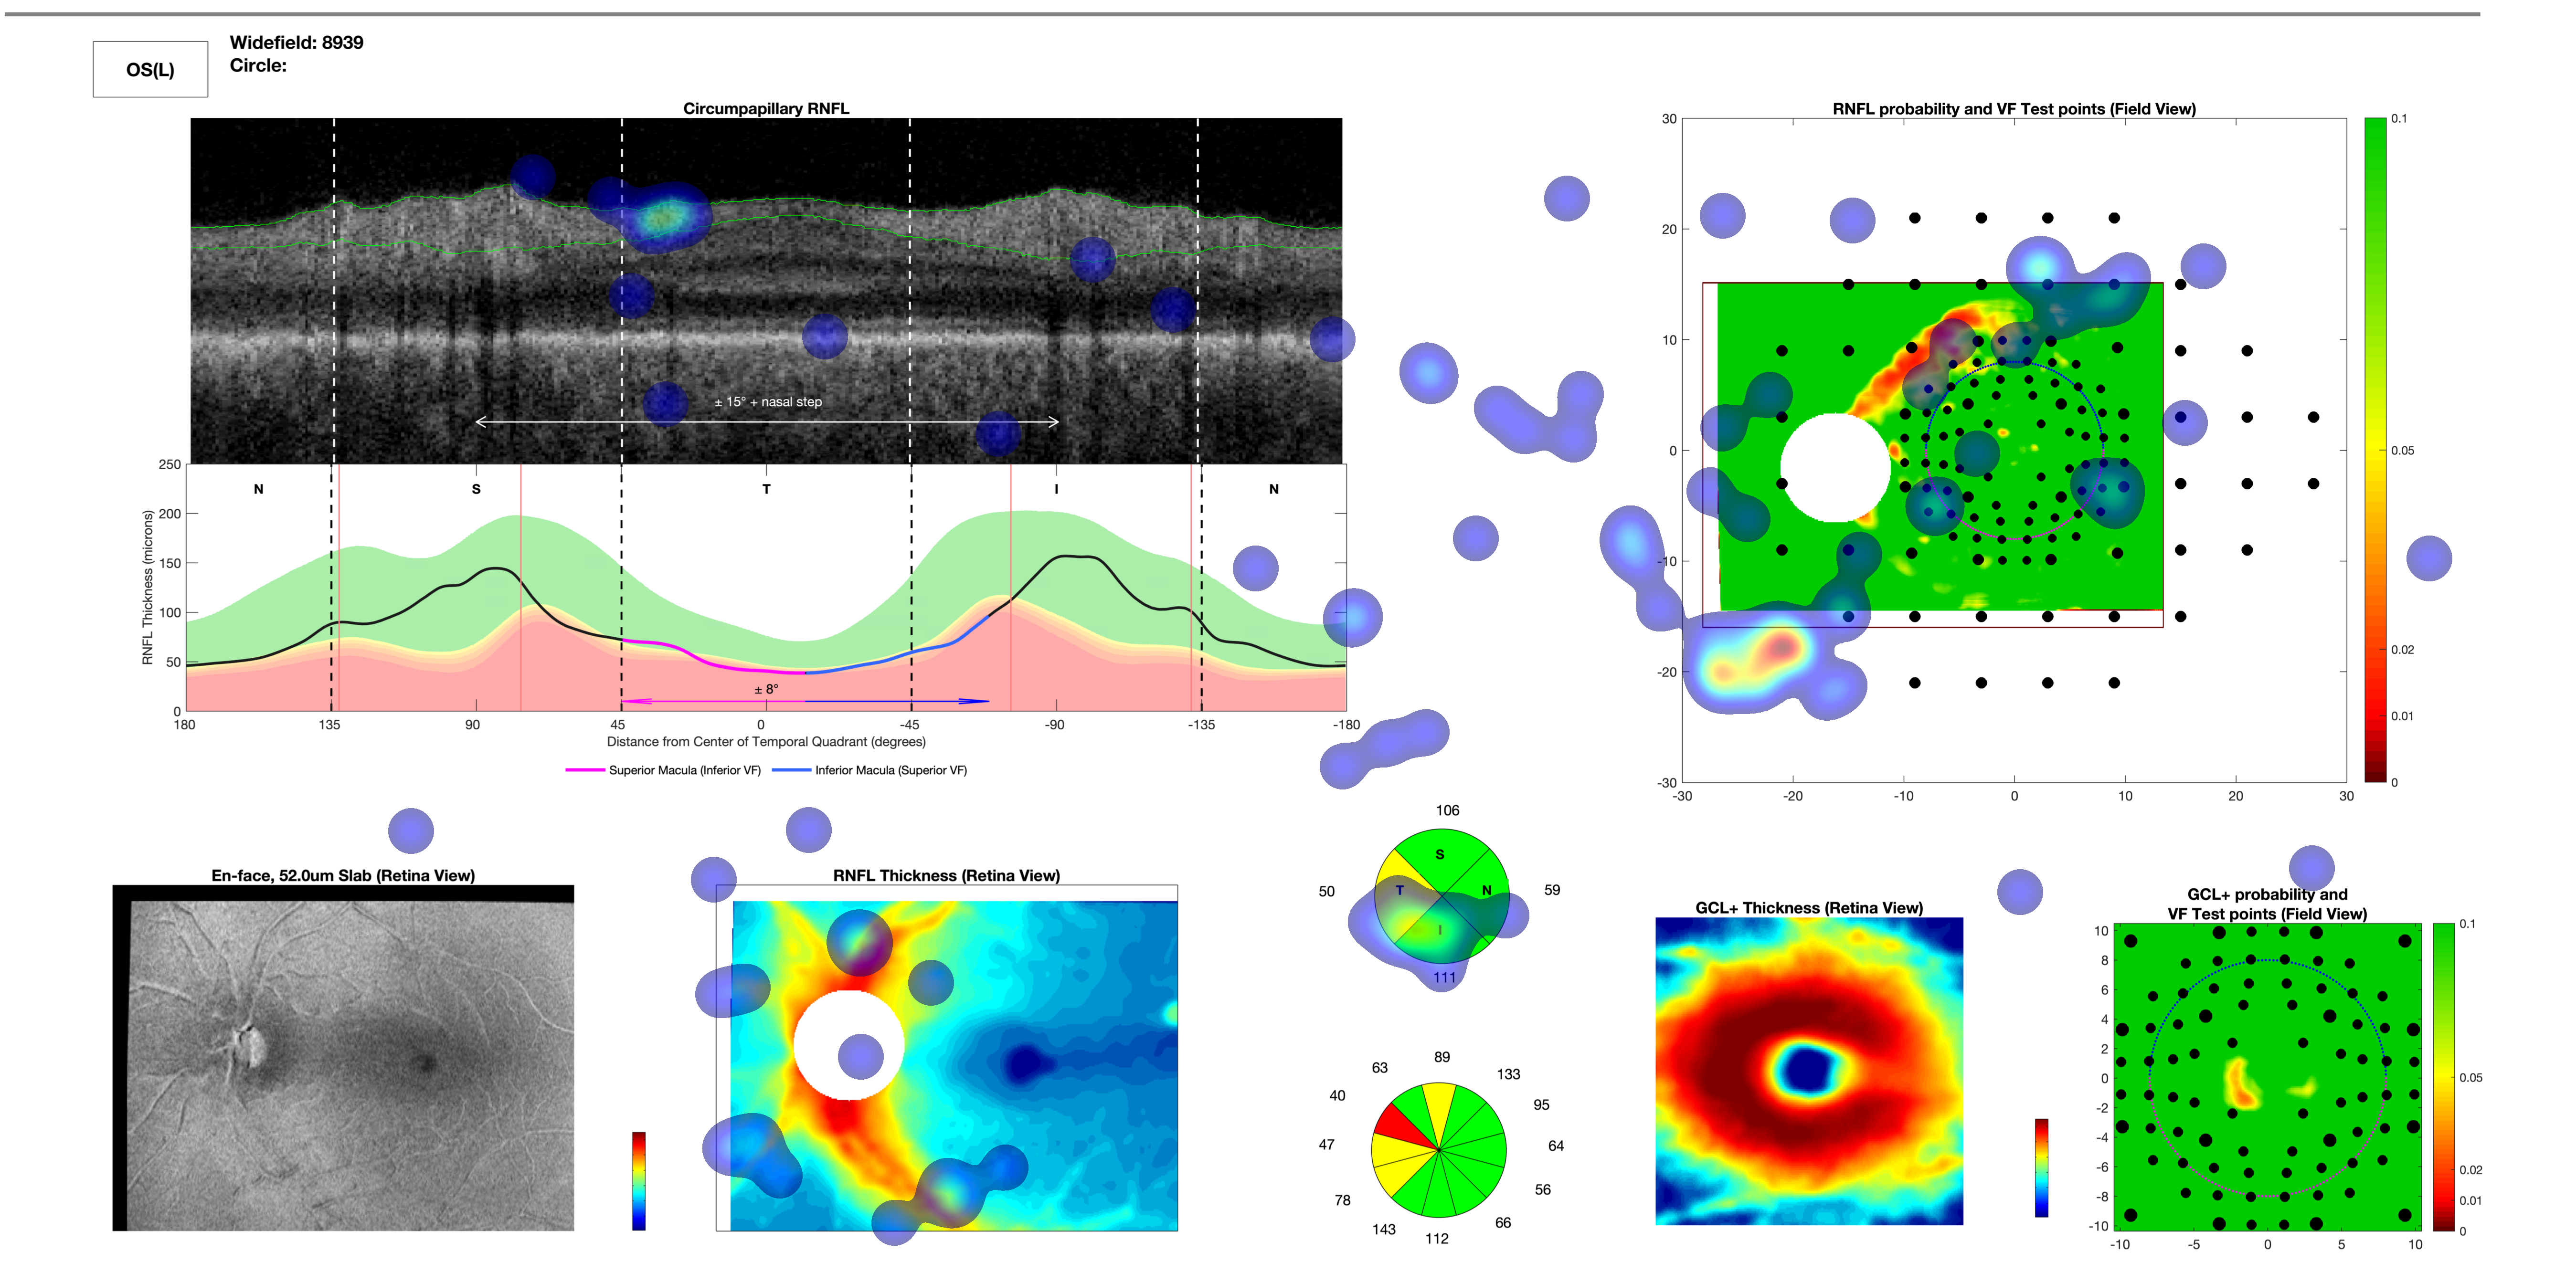

In [48]:
draw_heatmap(subset_df[['x', 'y', 'dur']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

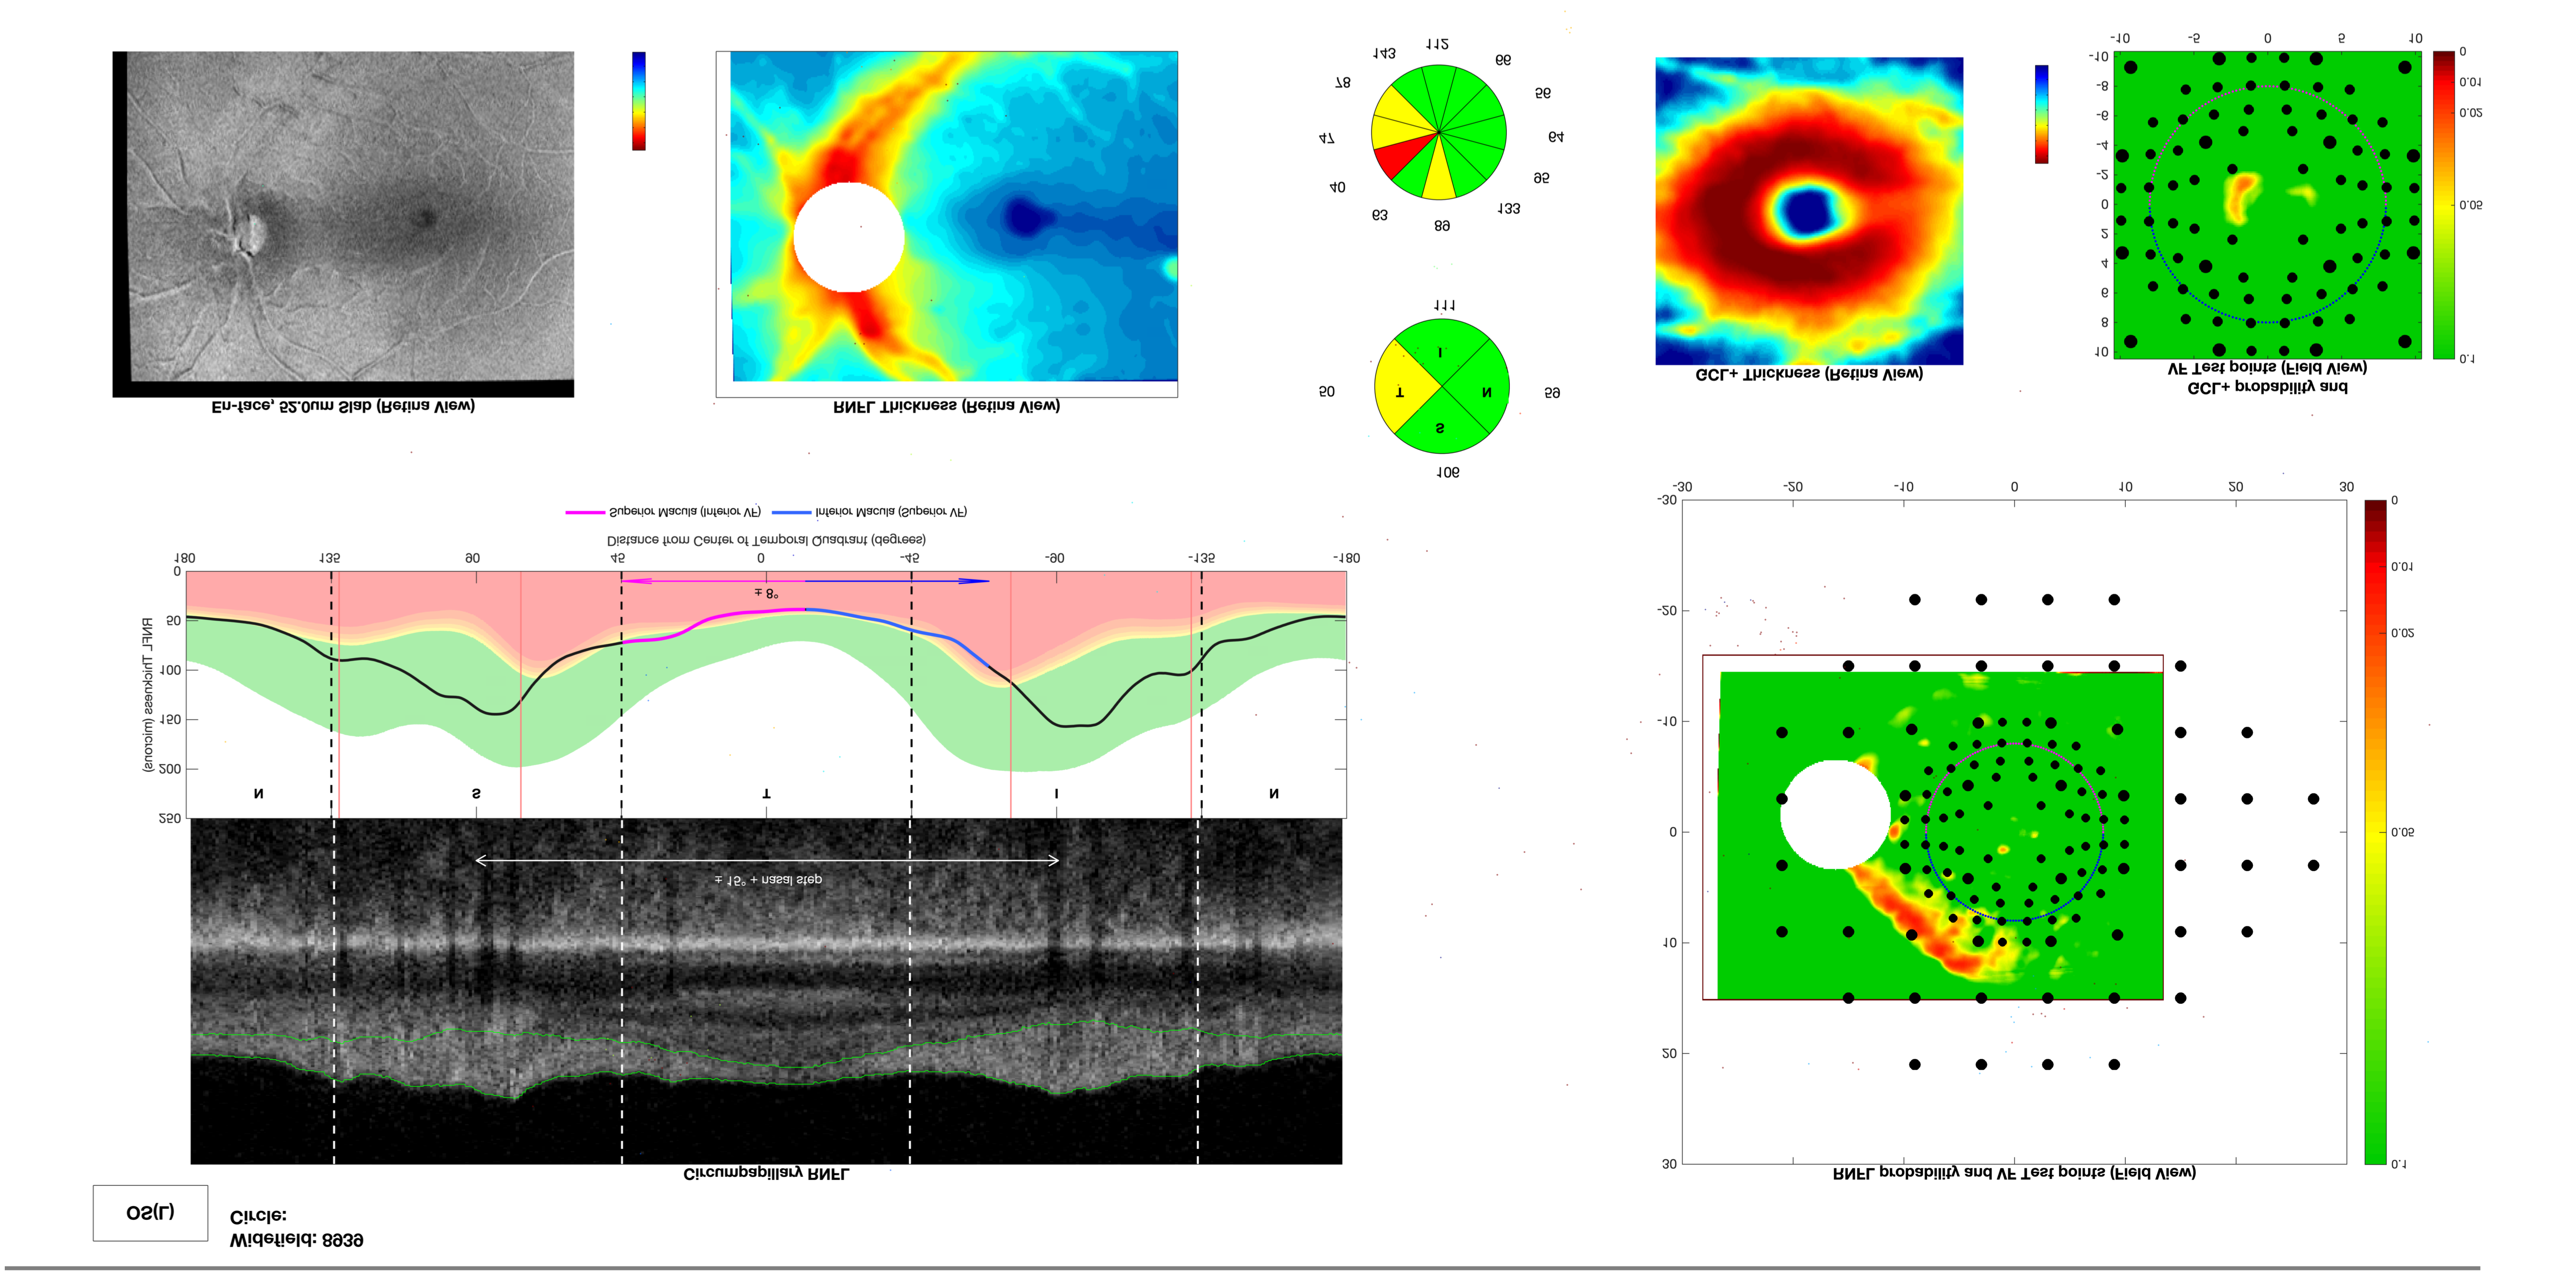

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

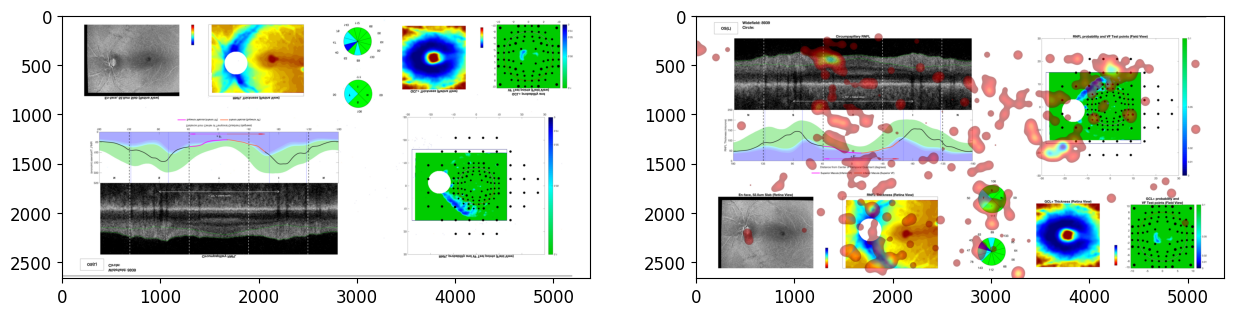

In [45]:
background_im = "/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/original_image/eem004_8939_original.png"
sub_fig = draw_fixations(subset_df[['x', 'y', 'dur']], (im_width, im_height), imagefile=background_im, alpha=0.5, savefilename=None)
plt.savefig("./data/expert_data/50-percentile.png")

fig, arr = plt.subplots(1, 2, figsize=(15, 15))
sub_img = cv2.imread("./data/expert_data/50-percentile.png")
arr[0].imshow(sub_img)
org = cv2.imread("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/heatmaps/eem004_8939heatmap.png")
arr[1].imshow(org)

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

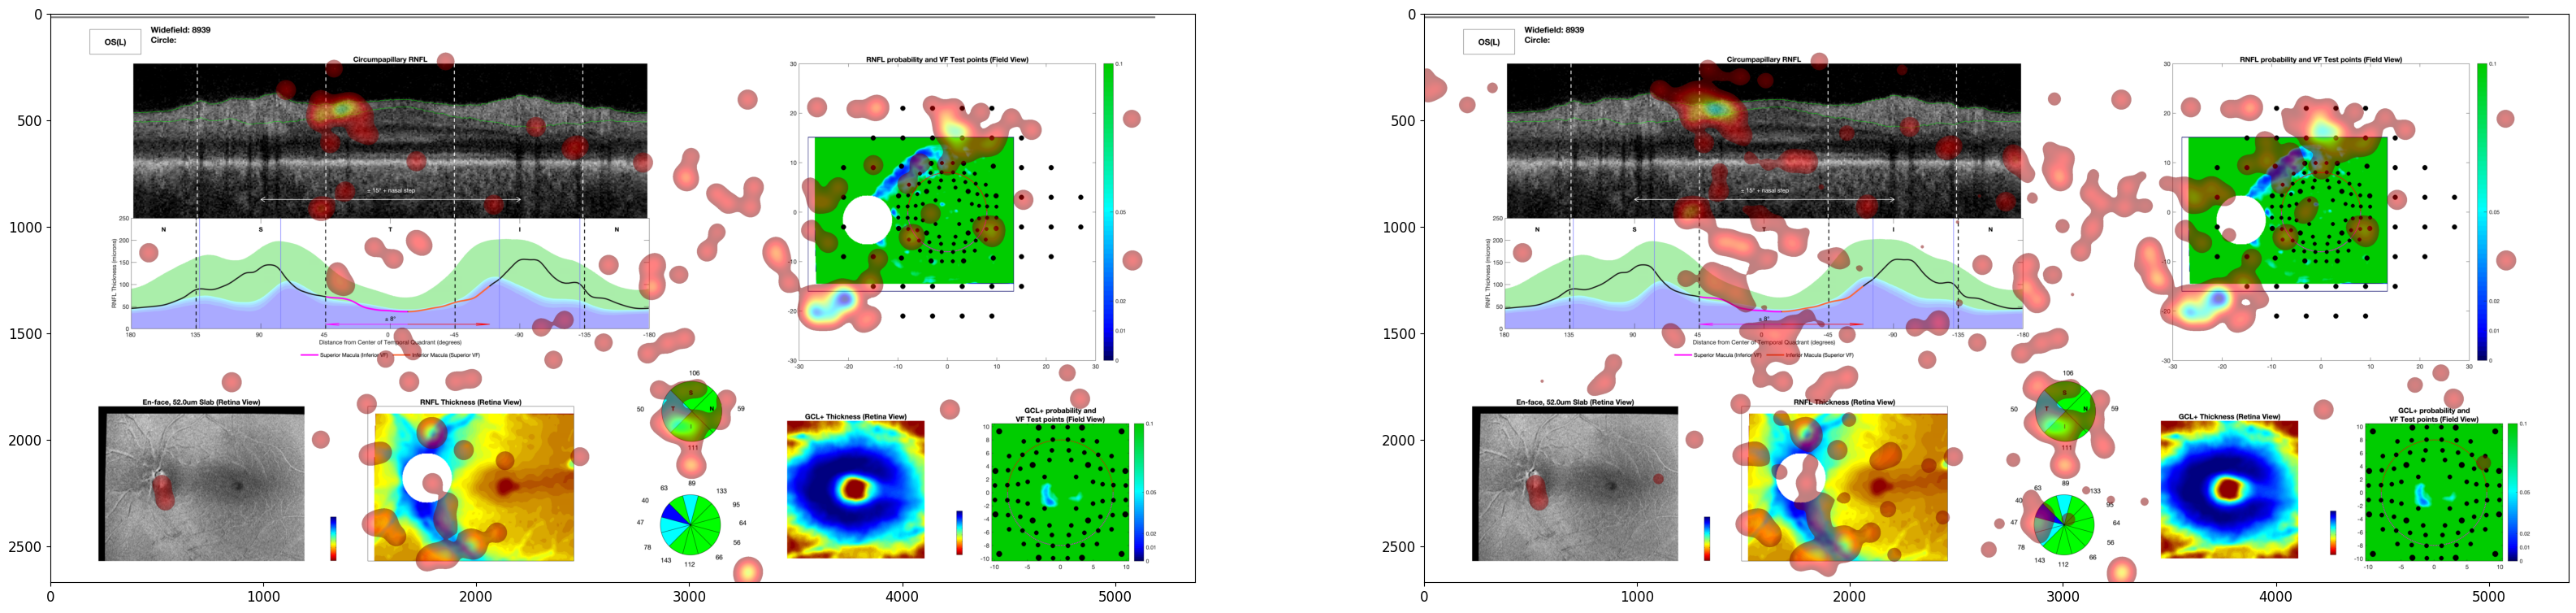

In [44]:
fig, arr = plt.subplots(1, 2, figsize=(40, 30))
sub_img = cv2.imread("./data/expert_data/50-percentile.png")
arr[0].imshow(sub_img)
org = cv2.imread("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/heatmaps/eem004_8939heatmap.png")
arr[1].imshow(org)

True

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

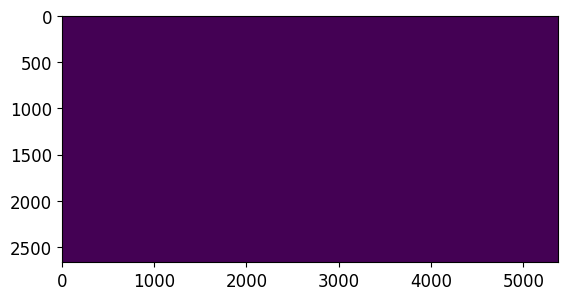

In [16]:
img = np.zeros((im_height, im_width, 1), dtype = "uint8")
plt.imshow(img)

cv2.imwrite('./data/expert_data/bsi.png', img)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

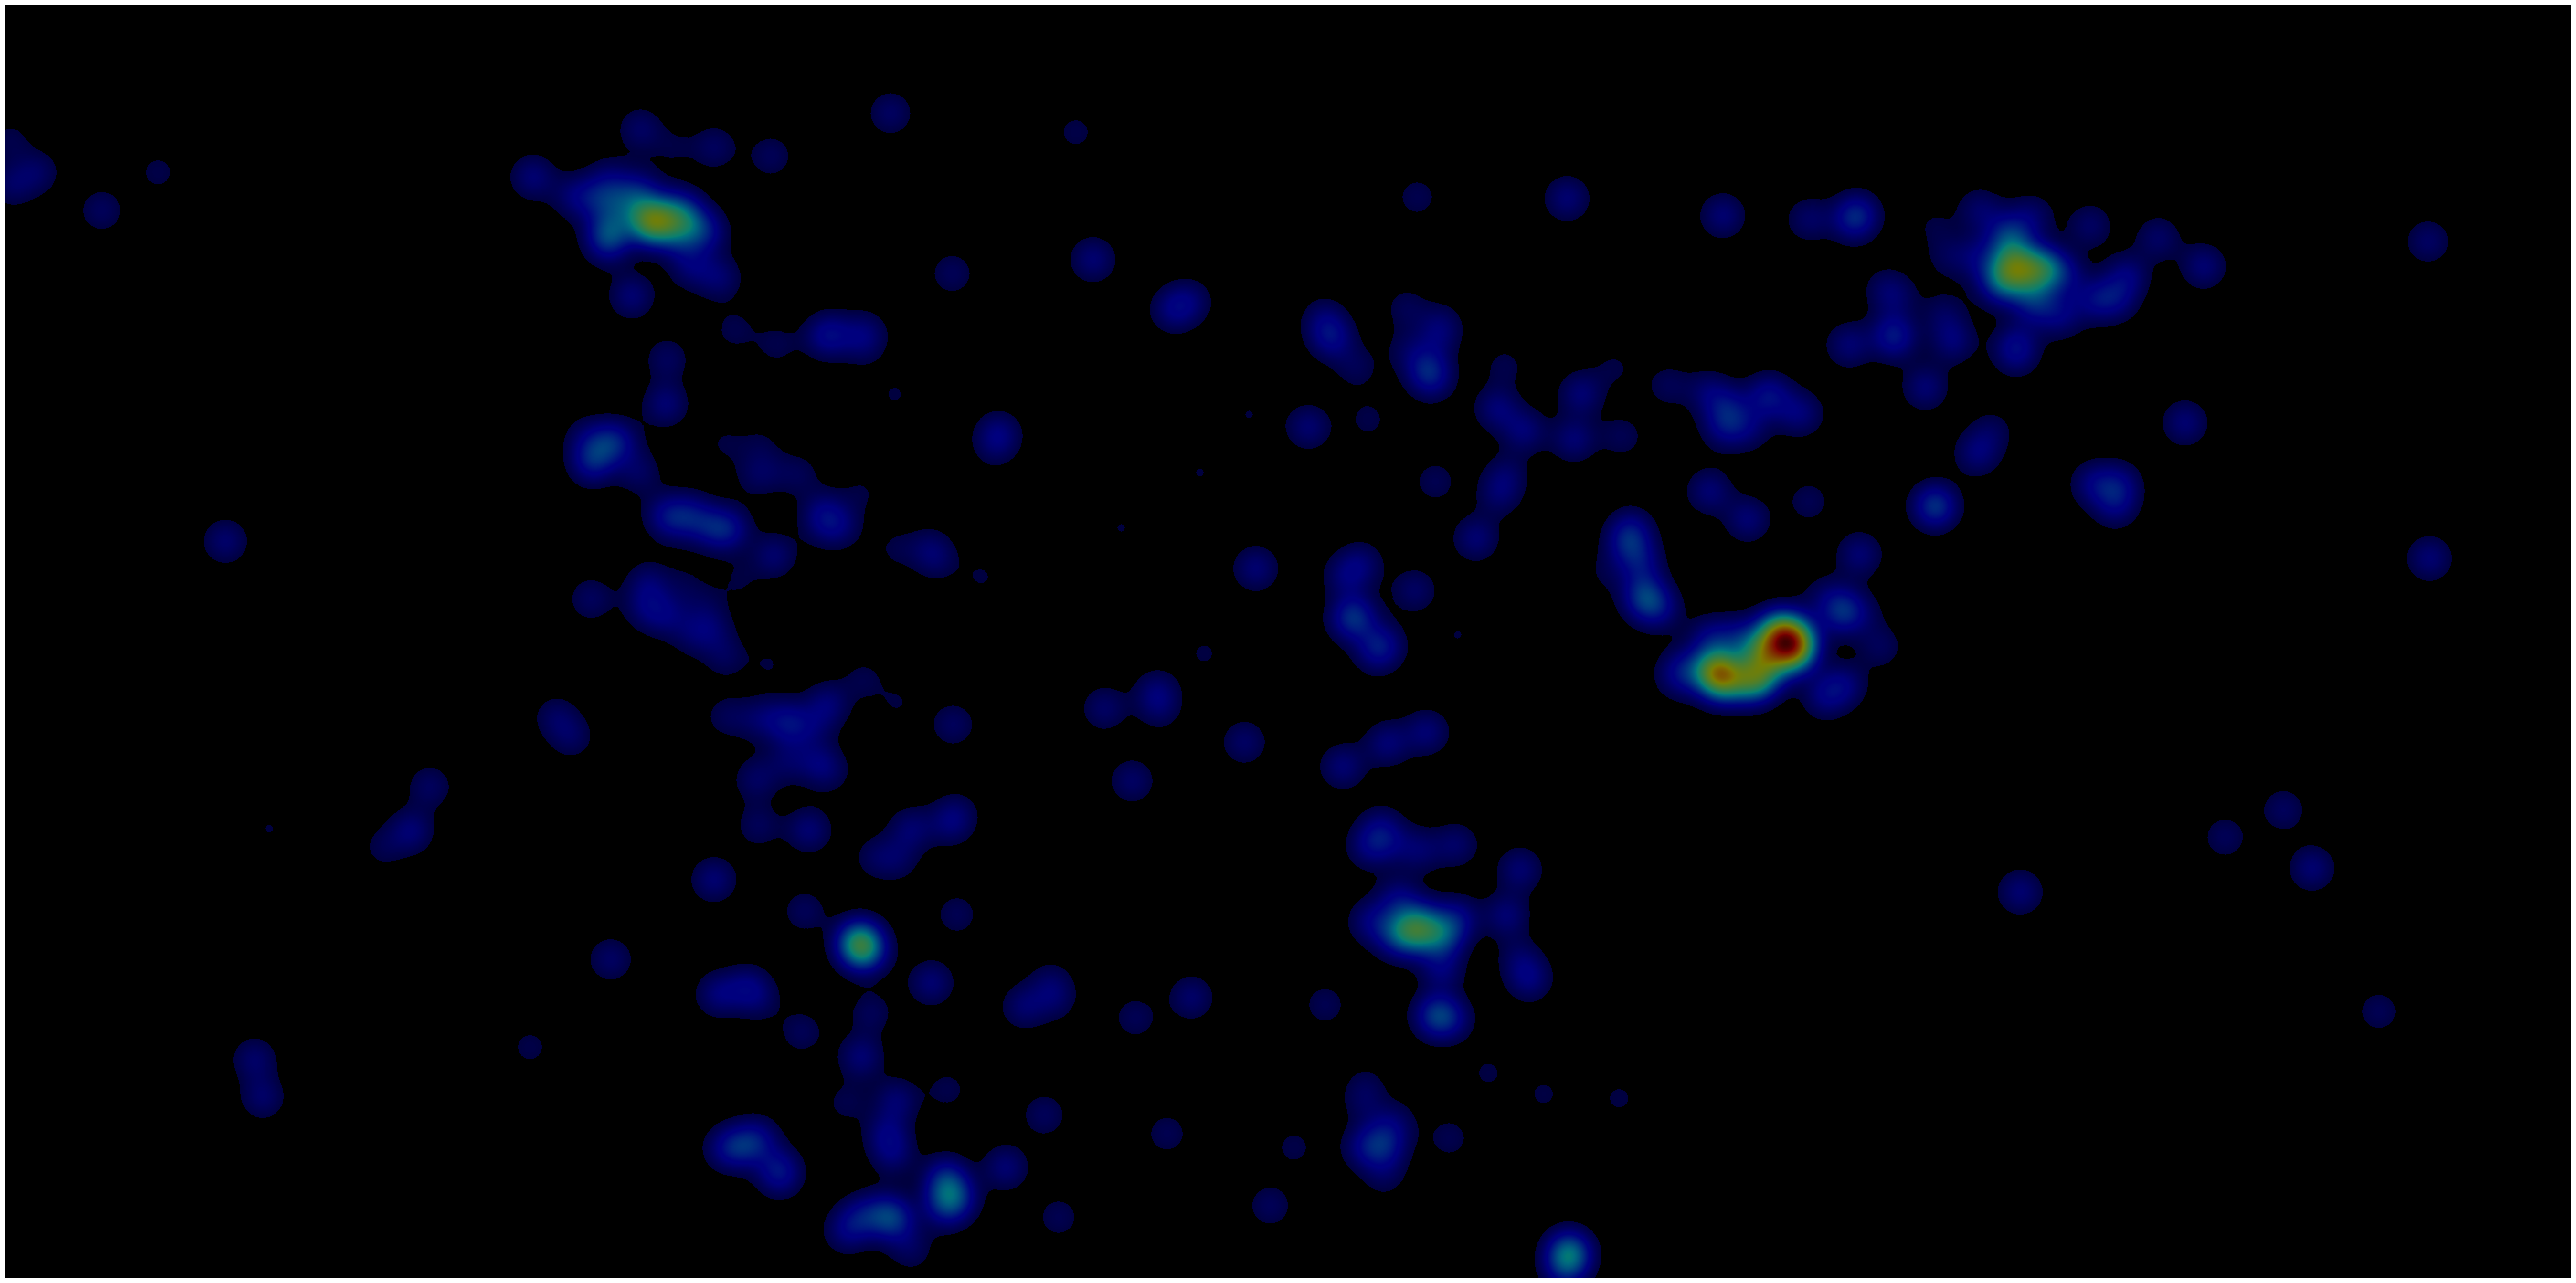

In [3]:
im_width, im_height = 5375, 2668
sub_df = pd.read_csv("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/fixations_eem004/fixations_Glaucoma_8939_OS_2021_widefield_report.csv")
sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
#draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration'
white_image = './data/expert_data/bsi.png'
draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration']], (im_width, im_height), imagefile=white_image)

In [5]:
from pygazeanalyser.gazeplotter import parse_fixations, draw_display

/var/folders/66/mwk1x7h96cgcvcj0wf91s_pc0000gn/T/ipykernel_40328/3932843256.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(fix['x'],fix['y'], marker='o', color='white', cmap='jet', edgecolors='none')


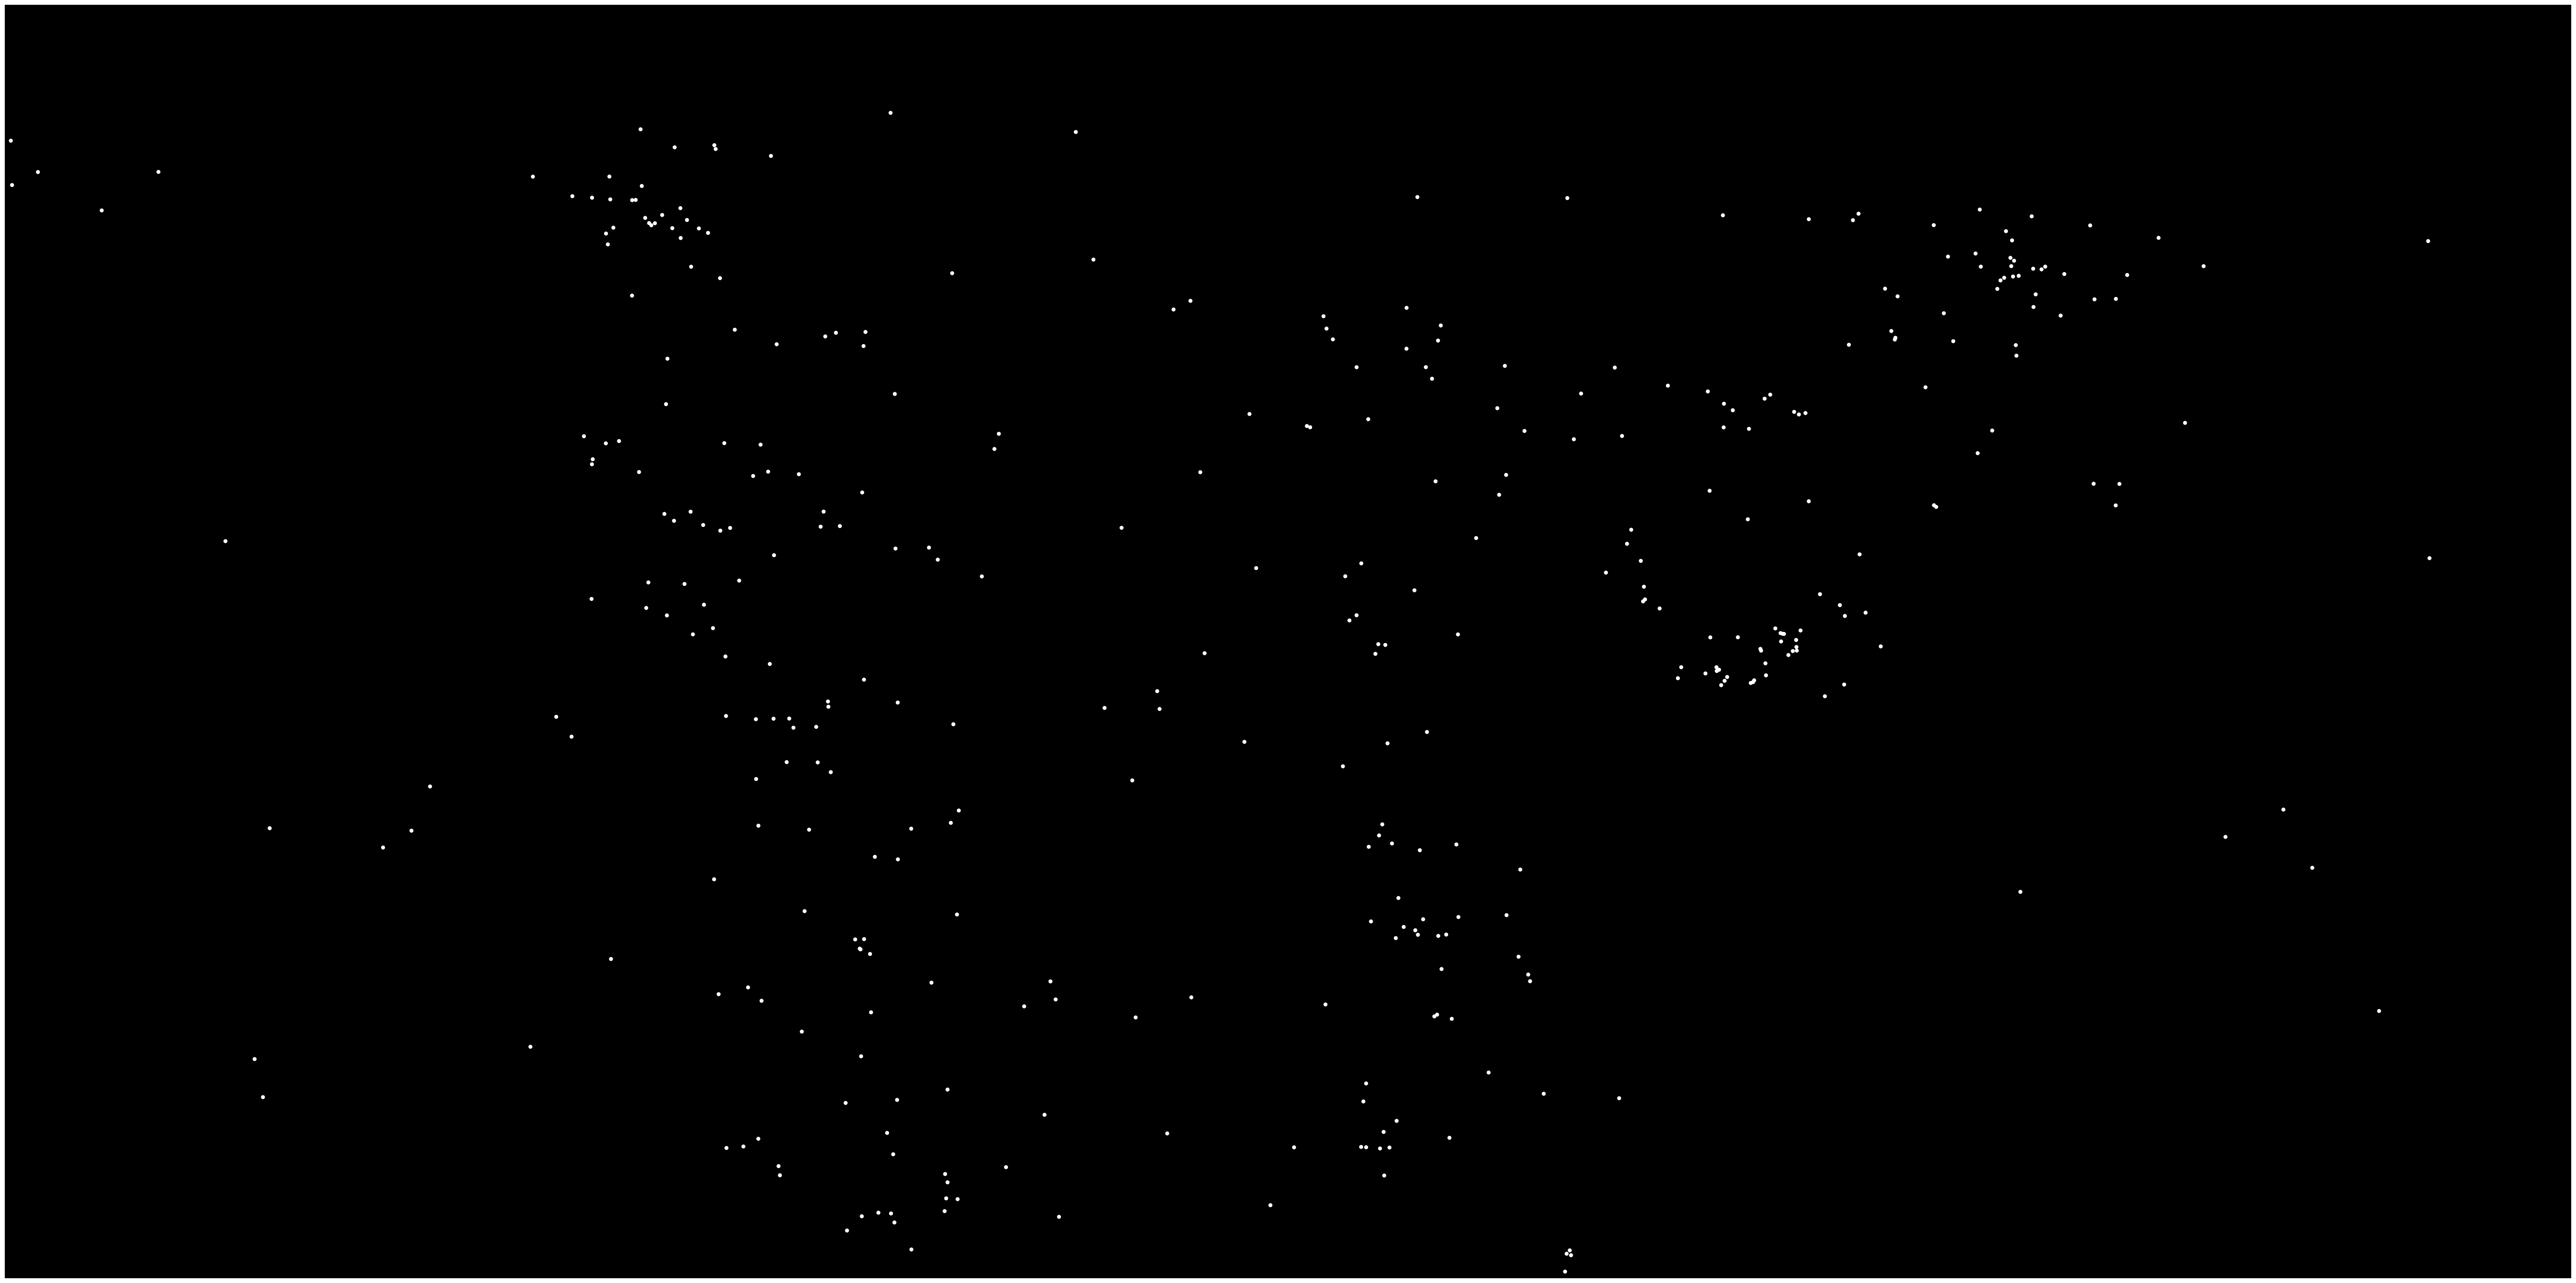

In [7]:
im_width, im_height = 5375, 2668
sub_df = pd.read_csv("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/1-26/eem004/fixations_eem004/fixations_Glaucoma_8939_OS_2021_widefield_report.csv")
sub_df['im_pos_x'] = sub_df['norm_pos_x']*im_width
sub_df['im_pos_y'] = sub_df['norm_pos_y']*im_height
#draw_heatmap(sub_df[['im_pos_x', 'im_pos_y', 'duration'
white_image = './data/expert_data/bsi.png'

fix = parse_fixations(sub_df[['im_pos_x', 'im_pos_y', 'duration']])


fig, ax = draw_display((im_width, im_height), imagefile=white_image)
ax.scatter(fix['x'],fix['y'], marker='o', color='white', cmap='jet', edgecolors='none')
fig.savefig("./data/expert_data/fixation-map.png")

Create masks and heatmaps for 12,13,14 

In [10]:
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/3-03/eem012/fixations_eem012")
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/3-08/eem013/fixations_eem013")
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/3-09/eem014/fixations_eem014")

In [41]:
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem009/fixations_eem009")


In [42]:
create_masks_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem009/fixations_eem009")

/var/folders/66/mwk1x7h96cgcvcj0wf91s_pc0000gn/T/ipykernel_11283/2031928547.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file)


In [47]:
get_original_image_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem009/fixations_eem009")

RLS_085_OS_TC
eem009 ['085_OS']
RLS_076_OD_TC
eem009 ['076_OD']
RLS_148_OS_TC
eem009 ['148_OS']
RLS_097_OS_TC
eem009 ['097_OS']
RLS_113_OS_TC
eem009 ['113_OS']
RLS_073_OS_TC
eem009 ['073_OS']
RLS_077_OD_TC
eem009 ['077_OD']
RLS_097_OD_TC
eem009 ['097_OD']
RLS_148_OD_TC
eem009 ['148_OD']
RLS_113_OD_TC
eem009 ['113_OD']
RLS_074_OD_TC
eem009 ['074_OD']
RLS_079_OD_TC
eem009 ['079_OD']
RLS_085_OD_TC
eem009 ['085_OD']
RLS_150_OD_TC
eem009 ['150_OD']
RLS_073_OD_TC
eem009 ['073_OD']
RLS_082_OD_TC
eem009 ['082_OD']
RLS_127_OD_TC
eem009 ['127_OD']
RLS_092_OS_TC
eem009 ['092_OS']
RLS_125_OS_TC
eem009 ['125_OS']
RLS_080_OS_TC
eem009 ['080_OS']


In [48]:
invert_bw_masks("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem009/binarized_masks")

In [60]:
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem016/fixations_eem016")
create_masks_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem016/fixations_eem016")
get_original_image_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem016/fixations_eem016")
invert_bw_masks("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem016/binarized_masks")

/var/folders/66/mwk1x7h96cgcvcj0wf91s_pc0000gn/T/ipykernel_11283/2031928547.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file)


RLS_057_OD_TC
eem016 ['057_OD']
RLS_047_OS_TC
eem016 ['047_OS']
RLS_091_OS_TC
eem016 ['091_OS']
RLS_064_OD_TC
eem016 ['064_OD']
RLS_093_OD_TC
eem016 ['093_OD']
RLS_083_OS_TC
eem016 ['083_OS']
RLS_084_OS_TC
eem016 ['084_OS']
RLS_086_OD_TC
eem016 ['086_OD']
RLS_095_OS_TC
eem016 ['095_OS']
RLS_093_OS_TC
eem016 ['093_OS']
RLS_087_OS_TC
eem016 ['087_OS']
RLS_097_OD_TC
eem016 ['097_OD']
RLS_047_OD_TC
eem016 ['047_OD']
RLS_091_OD_TC
eem016 ['091_OD']
RLS_014_OS_TC
eem016 ['014_OS']
RLS_084_OD_TC
eem016 ['084_OD']


In [9]:
create_heatmaps("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem012/fixations_eem012")

In [11]:
create_masks_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem012/fixations_eem012")
plt.close('all')
get_original_image_noncontrol("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem012/fixations_eem012")
invert_bw_masks("/Users/poojamukund/Documents/Vision Lab/UNET/data/expert_data/eem012/binarized_masks")
plt.close('all')

/var/folders/66/mwk1x7h96cgcvcj0wf91s_pc0000gn/T/ipykernel_2630/2031928547.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file)


RLS_057_OD_TC
eem012 ['057_OD']
RLS_036_OS_TC
eem012 ['036_OS']
RLS_039_OD_TC
eem012 ['039_OD']
RLS_018_OD_TC
eem012 ['018_OD']
RLS_064_OD_TC
eem012 ['064_OD']
RLS_024_OS_TC
eem012 ['024_OS']
RLS_023_OS_TC
eem012 ['023_OS']
RLS_028_OS_TC
eem012 ['028_OS']
RLS_078_OS_TC
eem012 ['078_OS']
RLS_031_OS_TC
eem012 ['031_OS']
RLS_018_OS_TC
eem012 ['018_OS']
RLS_095_OS_TC
eem012 ['095_OS']
RLS_024_OD_TC
eem012 ['024_OD']
RLS_064_OS_TC
eem012 ['064_OS']
RLS_036_OD_TC
eem012 ['036_OD']
RLS_025_OD_TC
eem012 ['025_OD']
RLS_031_OD_TC
eem012 ['031_OD']
RLS_014_OS_TC
eem012 ['014_OS']
RLS_033_OS_TC
eem012 ['033_OS']
RLS_023_OD_TC
eem012 ['023_OD']
